# CerealBar data processing
Data from https://github.com/lil-lab/cerealbar/tree/master/data

### 1 Extract JSON data
- Compute .csv of game data, per instruction line. Meta data collected includes: 
   - Game id
   - Score
   - Leader id
   - Follower id
   - Aligned (follower) actions
   - Instruction content
   - Number of tokens
   - PoS decomposition (spaCy) 
   
*For sorting games into 10 deciles of community life, see sengames_10buckets.csv*

### 2 Language Analysis
- 1. Complexity
- 2. Vocabulary size 

### 3 Extract Game-Specific behavior
- 1. Instruction-Queue size ('buffering' behavior)
- 2. Card Events
   - Proportion of selections and deselections
   - Computing the number of instructions per card event 
- 3. Excess moves ('wandering'), shortest distance 


In [23]:
import json, csv, pandas as pd, numpy as np, os, re, io, nltk, math
from nltk.corpus import stopwords
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scipy.spatial.distance as distance
import seaborn as sns
from sklearn import manifold
from itertools import combinations
from collections import Counter
import bz2

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/yoav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
#read in data from json file
with bz2.open("train.json.bz2", "r") as read_file:
    data = json.load(read_file)

#### 1.0 Collect Basic data per instruction line
- game id
- world time
- instruction id
- instruction text
- instruction PoS composition

Save in a csv for further processing

In [5]:
import spacy
from spacy.lang.en import English
from spacy.attrs import POS
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

     |████████████████████████████████| 12.8 MB 3.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
col_names = ['game_id', 'instruct_id', 'contents', 'text', 'doc', 'tokens', 'lemmas', 'pos', 'noun_chunks', 'numWords', 'unigrams', 'bigrams', 'trigrams', 'posCounts', 'NOUNcount', 'PROPNcount']
d = pd.DataFrame(columns = col_names)

In [7]:
def processgame(game_name, lead, foll, score, instr_id, contents, time, alignedacts):
    col_names = ['game_id', 'leader_id', 'follower_id', 'score', 'time', 'num_moves', 'instruct_id', 'contents', 'text', 'doc', 'tokens', 'lemmas', 'pos', 'noun_chunks', 'numWords', 'unigrams', 'bigrams', 'trigrams', 'posCounts', 'NOUNcount', 'PROPNcount', "NOUN", "PROPN", "DET", "PRON", "VERB", "ADJ", "CCONJ", "ADP", "ADV", "AUX", "SCONJ", "NUM"]
    d = pd.DataFrame(columns = col_names)
    
    gid = []
    gid.append(game_name)
    lid = [] 
    lid.append(lead)
    fid = []
    fid.append(foll)
    scr =[]
    scr.append(score)
    iid = []
    iid.append(instr_id)
    cont = []
    cont.append(contents)
    t = []
    t.append(time)
    aa = []
    aa.append(len(alignedacts))
    d['game_id'] = gid
    d['leader_id'] = lid
    d['follower_id'] = fid
    d['score'] = scr
    d['time'] = t
    d['instruct_id'] = iid
    d['num_moves'] = aa
    d['contents'] = cont
    
    nlp.max_length = 825000000

    d['text'] = [nlp(text) for text in d['contents']]
    d['tokens'] = [[token.text for token in l if not token.is_punct] for l in d['text']]
    d['pos'] = [[token.pos_ for token in l if not token.is_punct] for l in d['text']]
    d['noun_chunks'] = [list(l.noun_chunks) for l in d['text']]
    d['numWords'] = [len([token for token in l if not token.is_punct]) for l in d['text']]
    
    # from Hawkins tangrams. 3.2.1. extract parts of speech
    # https://github.com/hawkrobe/tangrams/tree/master/analysis
    tag_dict = {}
    tag_counts = {}
    for doc in d['text'] :
        for w in doc :
            if w.pos_ not in tag_dict :
                tag_dict[w.pos_] = w.pos
                tag_counts[w.pos_] = 0
            tag_counts[w.pos_] = tag_counts[w.pos_] + 1

    d['posCounts'] = [doc.count_by(spacy.attrs.POS) for doc in d['text']]
    for posStr in ["NOUN", 'SCONJ', "PROPN", "DET", "PRON", "VERB", "ADJ", "CCONJ", "ADP", "ADV", "AUX", "NUM"] : # 
        try:
            key_id = tag_dict[posStr]
            d[posStr + 'count'] = [counts[key_id] if key_id in counts else 0 for counts in d['posCounts']]
        except KeyError:
            {}
    # the spacy one likes to call article-less initial nouns proper nouns, so we combine them
    d['NOUNcount'] = d['NOUNcount'] + d['PROPNcount']

    return d

#### 1.1 Collect Basic data per instruction line
- aligned actions
- leader/follower id
- score

Join to csv for further processing

In [8]:
#col_names = ['game_id', 'instruct_id', 'contents', 'text', 'doc', 'tokens', 'lemmas', 'pos', 'noun_chunks', 'numWords', 'unigrams', 'bigrams', 'trigrams', 'posCounts', 'NOUNcount', 'PROPNcount', "NOUN", "PROPN", "DET", "PRON", "VERB", "ADJ", "CCONJ", "ADP", "ADV", "AUX", "SCONJ", "NUM"]
allgames = pd.DataFrame(columns = col_names)

# read in all instructions, process using processgame() to reading into csv
tot = []
#gameinstr = []
i = 0
count = 0
for (k, v) in data.items():
    lead = v['leader_id']
    foll = v['follower_id']
    scor = v['score']
    for act in v['actions']:
        if act['type'] == "instruction":
            if act['completed'] == False:
                aa = []
            else:
                aa = act['aligned_actions']
            d = processgame(k, lead, foll, scor, act['instruction_id'], act['instruction'], act['time'], aa)
            tot.append(d)
allgames = pd.concat(tot)

In [9]:
# save to a csv for further processing
allgames.drop(["tokens", 'posCounts', 'text', 'lemmas', 'noun_chunks', 'PROPNcount'], 1)
allgames.to_csv("cleaneddata.csv", index = False)

Add community decile labels to .csv from `sengames_10buckets.csv`

In [10]:
buckets = pd.read_csv("sengames_10buckets.csv")
blist = []
for index, row in allgames.iterrows():
    gid = row['game_id']
    try:
        b = buckets.loc[buckets['game_id'] == gid, 'bucket'].values[0]
    except:
        b = ""
    blist.append(b)
allgames['bucket'] = blist
allgames.to_csv("instrlines_bucket.csv", index = False)

## 2.0 Language analysis

### 2.1. Syntactic complexity
- Max width
- Max depth
- Average branch factor
- Average fertility
- Average jump distance
- Average chain length 

In [11]:
# define functions to calculate measures discussed above
# param: spacy.doc obj
# return: a float of the pre-normalized complexity 
"""
DEPTH
dependency chain lengths
take average of all of the depths
returns tuple of avg chain length and maximum depth of tree
"""
def chainlen_maxd(doc):
    d = []
    for tok in doc:
        d.append(get_depth(tok))
    return (sum(d)/len(d), max(d))

#tree depth
def get_depth(token):
    if not list(token.children):
        return 0
    else:
        return 1 + max(get_depth(x) for x in token.children)

"""
WIDTH
get widths at all depths of a tree
find maximum width
related measures: fertility, branching fct
"""
def get_width(doc):
    depdict = {}
    for tok in doc:
        dep = get_depth(tok)
        if get_depth(tok) not in depdict.keys():
            depdict[dep] = 0
            depdict[dep] += len(list(tok.children))
        else:
            depdict[dep] += len(list(tok.children))
    return max(depdict.values()) 

#'fertility' (average out-degree)
def get_od(token):
    return len(list(token.children))

def avg_fert(doc):
    d = []
    for tok in doc:
        d.append(get_od(tok))
    return sum(d)/len(d)

#branching factor
#avg OD of non-leaf nodes
def avg_branchfct(doc):
    d = []
    for tok in doc:
        od = get_od(tok)
        if(od > 0):
            d.append(od)
    if len(d)==0:
        return 0
    return sum(d)/len(d)


"""
JUMP DISTANCE
""" 
def jump_dist(doc):
    doclist = list(doc)
    strlist = []
    for tok in doclist:
        strlist.append(tok.text)
    d = []
    currind = 0
    for tok in doc:
        head = tok.head.text
        try:
            indh = strlist.index(head)
            dist = abs(indh-currind)
            dist -= 1
            d.append(dist)
        except ValueError:
            {}
        currind += 1
    return sum(d)/len(d)

In [13]:
#input text data (csv) and compute corresponding complexity measures 
#create spacy doc objects
import pandas as pd, numpy as np, os, sys, nltk, csv, math, spacy
from spacy.lang.en import English
from spacy.attrs import POS
nlp = spacy.load('en_core_web_sm')
from autocorrect import Speller
spell = Speller(lang='en')

d = pd.read_csv("instrlines_bucket.csv")
#create spacy doc objects 
d['text'] = [nlp(spell(text)) for text in d['contents']]
#spacy dependency parse
d['dependency'] = [[tok.dep_ for tok in doc] for doc in d['text']]
d['dep_pair'] = [[(tok.dep_, tok.head.pos_) for tok in doc] for doc in d['text']]

In [15]:
#use functions defined above to compute pre-normalized complexities
lengths = [chainlen_maxd(doc) for doc in d['text']]
d['max_depth'] = [depth for (avglen, depth) in lengths]
d['max_width'] = [get_width(doc) for doc in d['text']]
d['avg_branchfct'] = [avg_branchfct(doc) for doc in d['text']]
d['avg_fert'] = [avg_fert(doc) for doc in d['text']]
d['avg_chain'] = [avglen for (avglen, depth) in lengths]
d['jumps'] = [jump_dist(doc) for doc in d['text']]

#normalize complexity measures
davg = d.groupby(['numWords']).mean()['max_depth']
d['norm_max_depth'] = [dep/davg[nw] for (nw,dep) in zip(d['numWords'], d['max_depth'])]
mwavg = d.groupby(['numWords']).mean()['max_width']
d['norm_max_width'] = [mw/mwavg[nw] for (nw,mw) in zip(d['numWords'], d['max_width'])]
bfavg = d.groupby(['numWords']).mean()['avg_branchfct']
d['norm_branchfct'] = [bf/bfavg[nw] for (nw,bf) in zip(d['numWords'], d['avg_branchfct'])]
favg = d.groupby(['numWords']).mean()['avg_fert']
d['norm_avg_fert'] = [f/favg[nw] for (nw,f) in zip(d['numWords'], d['avg_fert'])]
chavg = d.groupby(['numWords']).mean()['avg_chain']
d['norm_avg_chain'] = [ch/chavg[nw] for (nw,ch) in zip(d['numWords'], d['avg_chain'])]
javg = d.groupby(['numWords']).mean()['jumps']
d['norm_jumps'] = [j/javg[nw] for (nw,j) in zip(d['numWords'], d['jumps'])]

#save outputs to csv
d.to_csv("complexity.csv", index=False)

<AxesSubplot:title={'center':'Max norm depth'}, xlabel='bucket'>

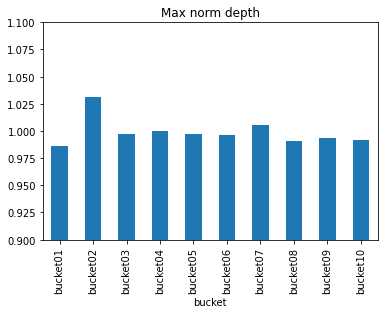

In [16]:
#norm depth over time
df = pd.read_csv("complexity.csv")
#average within games first, then average within buckets
normdepth = df.groupby(['game_id', 'bucket'])['norm_max_depth'].mean().groupby(['bucket'], sort=True).mean()
normdepth.plot(kind='bar', x='bucket', y='norm_max_depth', title="Max norm depth", ylim = (0.9, 1.1))

<AxesSubplot:title={'center':'Max norm width'}, xlabel='bucket'>

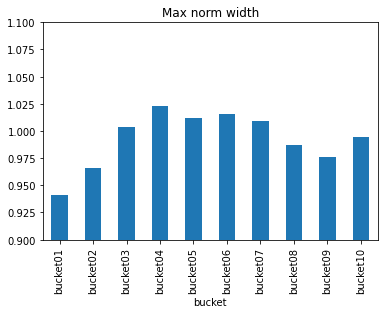

In [17]:
#norm width over time
df = pd.read_csv("complexity.csv")
#average within games first, then average within buckets
normwidth = df.groupby(['game_id', 'bucket'])['norm_max_width'].mean().groupby(['bucket'], sort=True).mean()
normwidth.plot(kind='bar', x='bucket', y='norm_max_width', title="Max norm width", ylim = (0.9, 1.1))

<AxesSubplot:title={'center':'Max norm branch factor'}, xlabel='bucket'>

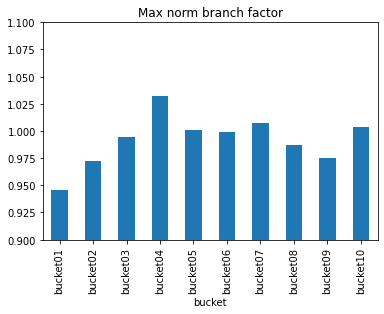

In [18]:
#norm branch factor over time
df = pd.read_csv("complexity.csv")
#average within games first, then average within buckets
normbranchfct = df.groupby(['game_id', 'bucket'])['norm_branchfct'].mean().groupby(['bucket'], sort=True).mean()
normbranchfct.plot(kind='bar', x='bucket', y='norm_branchfct', title="Max norm branch factor", ylim = (0.9, 1.1))

### 2.2 Vocabulary Size
Number of unique tokens per decile

In [19]:
def vocabulary_size(bucketGames):
    vocabulary_sz = []
    for bucket in bucketGames:
        unique_tokens = []
        for game in bucket:
            t = nltk.word_tokenize(game)
            for tok in t:
                tok = spell(tok)
                unique_tokens.append(tok)
        unique_tokens = set(unique_tokens)
        vocabulary_sz.append(len(unique_tokens))
    return vocabulary_sz

In [24]:
from autocorrect import Speller
spell = Speller(lang='en')
d = pd.read_csv("instrlines_bucket.csv")
langlist = []
# create lists of instructions for each bucket
sent_b01 = []
sent_b02 = []
sent_b03 = []
sent_b04 = []
sent_b05 = []
sent_b06 = []
sent_b07 = []
sent_b08 = []
sent_b09 = []
sent_b10 = []
for index, row in d.iterrows():
    instr = spell(row['contents'])
    bucket = row['bucket']
    if(bucket=="bucket01"):
        sent_b01.append(instr)
    elif(bucket=="bucket02"):
        sent_b02.append(instr)
    elif(bucket=="bucket03"):
        sent_b03.append(instr)
    elif(bucket=="bucket04"):
        sent_b04.append(instr)
    elif(bucket=="bucket05"):
        sent_b05.append(instr)
    elif(bucket=="bucket06"):
        sent_b06.append(instr)
    elif(bucket=="bucket07"):
        sent_b07.append(instr)
    elif(bucket=="bucket08"):
        sent_b08.append(instr)
    elif(bucket=="bucket09"):
        sent_b09.append(instr)
    elif(bucket=="bucket10"):
        sent_b10.append(instr)
langlist = [sent_b01,sent_b02,sent_b03,sent_b04,sent_b05,sent_b06,sent_b07,sent_b08,sent_b09,sent_b10]
vocab_size = vocabulary_size(langlist)

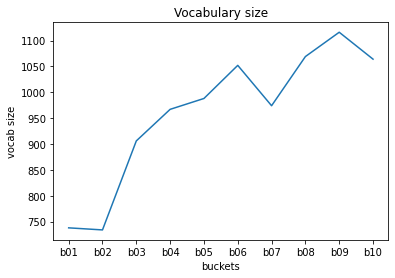

In [25]:
#vocab size over time
import matplotlib.pyplot as plt 
blst = ["b01", "b02", "b03", "b04", "b05", "b06", "b07", "b08", "b09", "b10"]
plt.plot(blst, vocab_size)
plt.xlabel('buckets')
plt.ylabel('vocab size')
plt.title("Vocabulary size")
plt.show()

### 2.3. Landmark References
We manually define the landmark classes `road`, `foliage`, `building`, `water`, `rock`, `ice`, and `light`.

In [26]:
import re
reroad = re.compile('road|fork|path|intersect|trail|crossroad|crosspath|walkway|cross')
refoliage = re.compile('palm|flower|tree|shrub|grass|pine|bush|grove|plant|conif|field|foliag|bushes|plants|wasteland|forest|clearing|patch|lawn')
rebuild = re.compile('tower|building|hous|tent|barn|fort|doghous|hut|village|cabin|shack|structur|shed|tower')
rewater = re.compile('lake|pond|water|sea|river|coast|lakeshor|island|shor')
rerock = re.compile('rock|cliff|boulde|mountain|hil|log|stone')
reice = re.compile('glacier|ice|iceberg')
relight = re.compile('post|lamp|pole|lamppost|light|streetlight|lightpost')

In [56]:
from autocorrect import Speller
spell = Speller(lang='en')
d = pd.read_csv("instrlines_bucket.csv")
d['road_use'] = [len(reroad.findall(spell(text))) for text in d['contents']]    
d['foliage_use'] = [len(refoliage.findall(spell(text))) for text in d['contents']]
d['build_use'] = [len(rebuild.findall(spell(text))) for text in d['contents']]
d['water_use'] = [len(rewater.findall(spell(text))) for text in d['contents']]
d['rock_use'] = [len(rerock.findall(spell(text))) for text in d['contents']]
d['ice_use'] = [len(reice.findall(spell(text))) for text in d['contents']]
d['light_use'] = [len(relight.findall(spell(text))) for text in d['contents']]
d.to_csv("instrlines_bucket.csv", index = False)

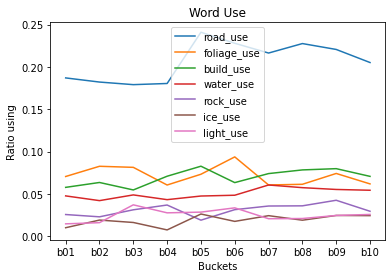

In [103]:
import matplotlib.pyplot as plt 
plt.figure()
blst = ["b01", "b02", "b03", "b04", "b05", "b06", "b07", "b08", "b09", "b10"]
use_dict = {}
for col in list(filter(lambda x: x.endswith('_use'), d.columns)):
    use = []
    for b in range(1,11):
        bd = d[d.bucket == 'bucket%02d' % b]
        use.append(len(list(filter(lambda x: x > 0, bd[col]))) / len(bd) )
    use_dict[col] = use
    plt.plot(blst, use, label= col)

plt.xlabel('Buckets')
plt.ylabel('Ratio using')
plt.title("Word Use")
plt.legend()
plt.show()

## 3.0 Collect Game-Specific interaction data 

### 3.1 Queuing Behavior
Collect info 
- Instruction given time
- Instruction completed time 
to compute queue (buffer) size

Measure queue behavior at three different points
-  3.1.1. Set made
-  3.1.2. Turn changed time, follower begins turn
-  3.1.3. Turn changed time, follower ends turn

Create separate .csv

In [105]:
with bz2.open("train.json.bz2", "r") as read_file:
    data = json.load(read_file)

In [106]:
# function to process one line of instruction, 
# returning a dataframe of assoc metadata that will be appended
# to the cummulative dataframe
def processgame(game_name, instr_id, t):
    col_names = ['game_id', 'instruct_id', 'time']
    d = pd.DataFrame(columns = col_names)
    gid = []
    gid.append(game_name)
    iid = []
    iid.append(instr_id)
    time = []
    time.append(t)
    d['game_id'] = gid
    d['instruct_id'] = iid
    d['time'] = time
    return d

In [107]:
# read in all instructions, process using processgame() to reading into csv
totgive = []
totfin = []
totsetmade = []
fbeginturn = []
fendturn = []
for (k, v) in data.items():
        lead = v['leader_id']
        scor = v['score']
        for act in v['actions']:
            #give instruction
            if act['type'] == "instruction":
                try:
                    d = processgame(k, act['instruction_id'], act['time'])
                    totgive.append(d)
                except KeyError:
                    {}
            #instruction marked as done
            if act['type'] == "finish command":
                try:
                    d = processgame(k, act['instruction_id'], act['time'])
                    totfin.append(d)
                except KeyError:
                    {}
            #set made
            if act['type'] == "movement" and act['set_result']['made_set']:
                d = processgame(k, "", act['time'])
                totsetmade.append(d)
            #follower begins turn
            if act['type'] == "begin turn" and act['character'] == "Follower":
                d = processgame(k, "", act['time'])
                fbeginturn.append(d)
            #follower ends turn
            if act['type'] == "end turn" and act['character'] == "Follower":
                d = processgame(k, "", act['time'])
                fendturn.append(d)
instrgive = pd.concat(totgive)
instrdone = pd.concat(totfin)
setmade = pd.concat(totsetmade)
beginturn = pd.concat(fbeginturn)
endturn = pd.concat(fendturn)

instrgive.loc[:,'type'] = "given"
instrdone.loc[:,'type'] = "done"
setmade.loc[:,'type'] = "setmade"
beginturn.loc[:,'type'] = "beginturn"
endturn.loc[:,'type'] = "endturn"

totdf = pd.concat([instrgive,instrdone,setmade, beginturn, endturn])
totdf = totdf.sort_values(by=['game_id', 'time'])
totdf = totdf.reset_index(drop=True)
totdf.to_csv("buffering_totanalysis.csv", index = False)

In [108]:
#compute buffer size at various measure points
for measure in ['setmade', 'beginturn', 'endturn']:
    buffer = []
    for index, row in totdf.iterrows():
        bsize = 0
        if(index!=0):
            if row['game_id']==totdf.iloc[index-1]['game_id']:
                bsize=buffer[index-1]
        if(row['type']=="given"):
            bsize+=1
        if(row['type']=="done"):
            bsize-=1
        if(row['type']==measure):
            bsize=buffer[index-1]
        buffer.append(bsize)
        l = len(buffer)
        if(l%10000==0):
            print(l)
    totdf['buffer_count'] = buffer
    
    #add bucket labels
    buckets = pd.read_csv("sengames_10buckets.csv")
    blist = []
    for index, row in totdf.iterrows():
        gid = row['game_id']
        try:
            b = buckets.loc[buckets['game_id'] == gid, 'bucket'].values[0]
        except:
            b = ""
        blist.append(b)
    totdf['bucket'] = blist
    #save to .csv
    totdf.to_csv("buffering_" + measure + ".csv", index=False)

10000
20000
30000
40000
50000
60000
70000
80000
90000
10000
20000
30000
40000
50000
60000
70000
80000
90000
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [109]:
#compute max buffer size reached in a game
dmax = totdf.groupby(['game_id'], sort=False)['buffer_count'].max()
dmax.to_csv("buffering_max.csv", index=True)

In [110]:
#max queue size over buckets
dmax = dmax.groupby(['game_id', 'bucket'])['buffer_count'].max().groupby(['bucket'], sort=True).mean()
dmax.plot(kind='bar', x='bucket', y='buffer_count', title="Max queue size over time")

KeyError: 'bucket'

In [ ]:
#queue size sampled follower begin turn over buckets
dfbegin = totdf.query('type == "change"')
#average within games first, then average within buckets
dfbegin = dfbegin.groupby(['game_id', 'bucket'])['buffer_count'].mean().groupby(['bucket'], sort=True).mean()
dfbegin.plot(kind='bar', x='bucket', y='buffer_count', title="Queue size sampled at start turn over time")

### 3.2. Card Events
For use in 
- Proportion of selections and deselections
- Computing the number of instructions per card event 

*Card event defined as a selection or deselection made by the leader or follower*

In [ ]:
#count activated card versus deactivated cards
def processgame(game_name, instr, cards, setmade):
    col_names = ['game_id', 'instruct_id', 'card_activ', 'card_deactiv', 'set_made']
    d = pd.DataFrame(columns = col_names)
    
    gid = []
    gid.append(game_name)
    iid = []
    iid.append(instr)
    cact = [0]
    cdeact = [0]
    if(cards != ""):
        if(cards[0]=="A"):
            cact[0]+=1
        if(cards[0]=="D"):
            cdeact[0]+=1
    sm = []
    sm.append(setmade)
    d['game_id'] = gid
    d['instruct_id'] = [instr]
    d['card_activ'] = cact
    d['card_deactiv'] = cdeact
    d['set_made'] = sm
    return d

In [ ]:
# read in all instructions, process using processgame() to reading into csv
tot = []
i = 0
for (k, v) in data.items():
        lead = v['leader_id']
        for act in v['actions']:
            if act['type'] == "movement":
                try:
                    d = processgame(k, act['instruction_id'], act['card_result'], act['set_result']['made_set'])
                    tot.append(d)
                except KeyError:
                    {}
allg2 = pd.concat(tot)
allg2['card_all'] = allg2['card_activ']+allg2['card_deactiv']
#allg2.to_csv("/../cardtouch_actdeact_leadfoll.csv", index=False)
allg2 = allg2.groupby(['game_id', 'instruct_id'])['card_all'].sum().reset_index()
allg2.to_csv("cardtouch_actdeact_leadfoll.csv", index=False)

In [ ]:
# proportion of card events that are de/activations
df_trunc1 = allg2[['bucket', 'cards_activated', 'cards_deactivated']]
sub_df1 = df_trunc1.groupby(['bucket'])['cards_activated', 'cards_deactivated'].sum()
propdeact = []
for index, row in sub_df1.iterrows():
    deact = row['cards_deactivated']
    act = row['cards_activated']
    propdeact.append(deact/(deact+act))
sub_df1['prop_deact'] = propdeact
sub_df1.plot(kind='line', x='bucket', y='prop_deact', ylim = (0.04,0.08), title="Prop of card events that were deselections")

### 3.3. Excess moves ('wandering'), shortest distance 


In [ ]:
# Loading train json data
with open('train.json') as json_file:
    trainData = json.load(json_file) # save json into a variable
# Imports from local cerealbar modules
"""
Note: 
I have experienced strange bugs while running this.
I've solved this by running this section with `from agent.simulation.planner import *` uncommented in
followed by the next section, then commenting it and running this section again.
"""
from agent.environment import *
from agent.simulation.rotation_planner import *
from agent.environment.position import *
from agent.environment.rotation import *
from agent.environment.agent import *
from agent.simulation.planner import *
from agent.environment.terrain import *
from agent.simulation import *
from agent.simulation import rotation_planner
from agent.evaluation import metric
import sys

# The shortest path algorith (heuristic)
# By default, it sets a backward cost of 3.5. We will make this 0 in a later section.
# This algorithm is located in `planner.py` of the simulations directory of cerealbar.
"""
It doesn't give an exact shortest path. 

We must use `get_new_player_orientation` (also in planner.py) to do so when using
this shortest path algorithm.
"""
def find_path_between_positions(
    avoid_locations: List[position.Position],
    start_config: agent.Agent,
    target_config: agent.Agent,
    ignore_target_rotation: bool = False
):
    """Finds a path between two positions in the map.

    Args:
        avoid_locations: A list of locations to avoid, including obstacles and cards that should not be touched.
        start_config: The starting configuration (position/rotation) of the agent.
        target_config: The target configuration (position/rotation) of the agent.
        ignore_target_rotation: Whether the final rotation of the agent matters.
    """
    queue: PositionRotationQueue = PositionRotationQueue()
    queue.put(start_config.get_position(), start_config.get_rotation(), 0)
    paths: Dict[Tuple[position.Position, rotation.Rotation],
                Optional[Tuple[Tuple[position.Position, rotation.Rotation],
                               List[agent_actions.AgentAction]]]] = dict()
    paths[(start_config.get_position(), start_config.get_rotation())] = None

    total_dist: Dict[Tuple[position.Position, rotation.Rotation], int] = dict()
    total_dist[(start_config.get_position(), start_config.get_rotation())] = 0

    has_ended: bool = False
    current_pos_and_rot: Tuple[Optional[position.Position],
                               Optional[rotation.Rotation]] = (None, None)
        

    while not queue.is_empty():
        current_pos_and_rot: Tuple[position.Position,
                                   rotation.Rotation] = queue.get()
        current_position: position.Position = current_pos_and_rot[0]
        current_rotation: rotation.Rotation = current_pos_and_rot[1]
        if current_position == target_config.get_position(): # If we've reached our target, break out of the while loop
            has_ended = True
            break

        for next_position in position.get_neighbors(
                current_position, environment_util.ENVIRONMENT_WIDTH,
                environment_util.ENVIRONMENT_DEPTH):
            if next_position not in avoid_locations:
                action_rot_pairs: List[Tuple[
                    List[agent_actions.AgentAction], rotation.
                    Rotation]] = rotation_possibilities(current_position, next_position, current_rotation)

                # There could be several ways to get from one hex to another by rotation. Iterate through all of them,
                # considering the cost of backwards moves.
                for move_possibility in action_rot_pairs:
                    actions: List[
                        agent_actions.AgentAction] = move_possibility[0]
                    resulting_rotation: rotation.Rotation = move_possibility[1]

                    new_dist: int = total_dist[
                        current_pos_and_rot] + follower_action_cost(actions)

                    move_pair: Tuple[position.Position,
                                     rotation.Rotation] = (next_position,
                                                           resulting_rotation)
                    if new_dist < total_dist.get(move_pair, sys.maxsize):
                        total_dist[move_pair] = new_dist
                        paths[move_pair] = (current_pos_and_rot, actions)
                        priority: int = new_dist + metric.manhattan_distance(
                            target_config.get_position(), next_position)
                        queue.put(next_position, resulting_rotation, priority)

    if not has_ended: 
        """
        Condition occurs if the queue is empty.
        """
        return None
    

    final_rotation: rotation.Rotation = current_pos_and_rot[1]
    path_positions: List[position.Position] = []
    actions: List[agent_actions.AgentAction] = []

    while current_pos_and_rot != (start_config.get_position(),
                                  start_config.get_rotation()):
        segment_actions = paths[current_pos_and_rot][1]
        segment_actions.reverse()
        actions += segment_actions
        path_positions.append(current_pos_and_rot[0])
        current_pos_and_rot = paths[current_pos_and_rot][0]

    actions.reverse()
    path_positions.reverse()

    if not ignore_target_rotation and target_config.get_rotation(
    ) != final_rotation:
        num_right: int = 0
        temp_right_rotation: rotation.Rotation = final_rotation
        while temp_right_rotation != target_config.get_rotation():
            num_right += 1
            temp_right_rotation = rotation.rotate_clockwise(
                temp_right_rotation)

        if num_right <= 3:
            actions.extend(
                [agent_actions.AgentAction.RR for _ in range(num_right)])
        else:
            actions.extend(
                [agent_actions.AgentAction.RL for _ in range(6 - num_right)])

    path_positions = [start_config.get_position()] + path_positions

    # Now create an actual list of states and actions
    position_action_list: List[Tuple[agent.Agent,
                                     agent_actions.AgentAction]] = list()
    pos_idx: int = 0
    current_rotation: rotation.Rotation = start_config.get_rotation()
    for action in actions:
        position_action_list.append(
            (agent.Agent(environment_objects.ObjectType.FOLLOWER,
                         path_positions[pos_idx], current_rotation), action))
        if action in {
                agent_actions.AgentAction.MF, agent_actions.AgentAction.MB
        }:
            pos_idx += 1
        elif action in {
                agent_actions.AgentAction.RR, agent_actions.AgentAction.RL
        }:
            if action == agent_actions.AgentAction.RR:
                current_rotation = rotation.rotate_clockwise(current_rotation)
            else:
                current_rotation = rotation.rotate_counterclockwise(
                    current_rotation)
        else:
            raise ValueError('Action should not be generated: ' + str(action))

    # Should end up in the expected rotation.
    if not ignore_target_rotation:
        assert current_rotation == target_config.get_rotation()
        

    return position_action_list

#### Retrieve data from game_states.pkl
The variables `game_states` contains the environment status for each game.
We will retrieve:
1. Location of obstacle terrain
2. State of the follower (position, rotation) 

In [ ]:
from agent.environment.state_delta import *
# Unpickle
pickle_off = open("./agent/preprocessed/game_states.pkl","rb")
game_states = pickle.load(pickle_off)

# Parameter: a game object
# Result: filtered/processed actions array
def alignJsonGames(game):
    # Trying to align state changes with actions
    rotation_actions = ['RR', 'RL']

    test_actions = copy.deepcopy(game.actions) # do not alter original actions
    actions_to_remove = []
    final_actions = []
    for a in test_actions:
        if('resulting_position' in a.keys() and 'resulting_rotation' in a.keys()):
            if(a['resulting_position'] == 'same'):
                if(a['action'] not in rotation_actions):
                    actions_to_remove.append(a)
        if('action' in a.keys()):
            if(a['action'] == 'initial'): 
                test_actions.remove(a)
        if('type' in a.keys()):
            if(a['type'] == 'begin turn' or a['type'] == 'end turn' or a['type'] == 'instruction' or a['type'] == 'finish command'):
                actions_to_remove.append(a)
    
    for a in test_actions:
        if(a not in actions_to_remove):
            final_actions.append(a)
    
    return final_actions

# Testing out in all games
processedGames = []

for g in games:
    curGameID = g.gameID
    curInstructions = g.instructions
    curCardsTouched = g.cardsTouched
    curDate = g.date
    curCBucket = g.cBucket
    curActions = alignJsonGames(g)
    
    currentGame = cerealGame(curGameID, curInstructions, curCardsTouched, curDate, curCBucket, curActions)
    processedGames.append(currentGame)

# Checking results
print("Processed | Unprocessed")
print("--------------------------------")
print("Length of Game List: ", len(processedGames), len(games))
print("Length of Actions List:")
print("Processed | Action State Deltas")
for g in range(960):
    print(games[g].gameID, len(processedGames[g].actions), len(game_states[games[g].gameID].state_deltas), '\n\n')
    
# TEST: Fix rotations in processedGames
for g in range(960):
    for a in range(len(processedGames[g].actions)):
        processedGames[g].actions[a]['resulting_rotation'] = game_states[games[g].gameID].state_deltas[a].to_dict()['follow']['rot']
    
    print(games[g].gameID)
    for a in processedGames[g].actions:
        print(a, '\n')

# Fix rotations in games

for g in range(960):
    for a in games[g].actions:
        if(a in processedGames[g].actions):
            a['resulting_rotation'] = game_states[games[g].gameID].state_deltas[processedGames[g].actions.index(a)].to_dict()['follow']['rot']

    print(games[g].gameID)
    for a in games[g].actions:
        print(a, '\n')

In [ ]:
# Helper functions

# Parameter: a string of "x, y" position coordinates from train.json
# Result: a tuple of (x, y) positions
def tuplefyCoords(stringCoords):
    s = stringCoords.split(',')
    return (s[0], s[1])

# Parameter: string of game ID
# Result: a list of avoid locations (Position)
def getAvoidLocs(gameID):
    avoid_locations = []
    for i in game_states[gameID].hexes:
        if(i[0] in OBSTACLE_TERRAINS):
            avoid_locations.append(i[1])
    return avoid_locations

# Parameter: a card object
# Result: a string in the form of "1 card_red Triangle" # number + card_ + color + Shape
def interpretCard(cardObj):
    card = str(cardobj.get_card_count())
    return card

# Parameter: string of gameID
# Result: dictionary of instruction ID:card
def getCardLocs(gameID):
    for i in game_states[gameID].state_deltas:
        print(i.cards[4])
        
# Helper classes
class TravelPoint:
    def __init__(self, p, r):
        self.position = p
        self.rotation = r
        
    def printPoint(self):
        print(self.position, self.rotation)

class Card:
    def __init__(self, d, p, r):
        self.description = d
        self.position = p
        self.rotation = r
        
    def printCard(self):
        print(self.description, self.position, self.rotation)
        
# For writing to the CSV
# field names  
fields = ['gameID', 'algoLen', 'algoPath', 'actualLen', 'actualPath']  

# name of csv file  
filename = "wandering-fin.csv"

# data rows of csv file  
rows = []

In [ ]:
"""
Use function above to get actual shortest patch possible.
Revised method needs to take sub distances between cards if necessary.
Goal is to find shortest path between cards touched.

Note: the below steps could be separated out, but it just does it all in one currently.

2. Put all start and target pos for each instruction into an array of tuples.
    - First get all follower actions to correspond to each leader instruction. Probably a dictionary with array value.
    - Manage 'same' results in follower position changes.
    - Start position/rotation is follower's first explicit start position/rotation (not 'same')
    - End position/rotation will be the last instruction of the instruction or 'N/A' if follower never completed it
"""

# Iterate through senior games from train.json
for g in games:
    new_pos, new_rot = None, None
    # Do the following for each senior game:
    """
    Main variables
    """
    
    aa = [] # all aligned actions
    aa_keys = [] # all instruction ids of aligned actions
    fa = [] # all follower actions
    
    taken_dict = {} # instruction id : length of actual taken actions
    taken_actions_dict = {} # instruction id : actual taken actions (hard to read)
    resulting_pos_dict = {} # instruction id : resulting_positions array
    resulting_rot_dict = {} # instruction id : resulting_rotation array
    instruction_dict = {} # instruction ID with a list target point objects to calculate distance between
        # start point, any points in between, end point

        
    """
    Retrieving leader instruction and follower taken actions info from the game.
    """    
    # aa
    for a in g.actions:
        if('aligned_actions' in a.keys()):
            if(len(a['aligned_actions']) > 1):
                aa.append(a)
                aa_keys.append(a['instruction_id'])
    # fa            
    for a in g.actions:
        if('instruction_id' in a.keys()):
            if(a['instruction_id'] in aa_keys):
                if('character' in a.keys() and 'action' in a.keys()):
                    if(a['character'] == 'Follower' and a['action'] != 'initial'):
                        fa.append(a)
                
    # taken_dict
    # taken_actions_dict
    for a in aa:
        if(len(a['aligned_actions']) >= 1):
            taken_dict[a['instruction_id']] = len(a['aligned_actions'])
            taken_actions_dict[a['instruction_id']] = a['aligned_actions']
            
    """
    For each instruction, gather the resulting position and rotation data to make points later. 
    """ 
    # gather the resulting_positions for each instruction 
    for a in fa:
        # remove no-move instructions
        less_than_one = False
        for j in aa:
            if(j['instruction_id'] == a['instruction_id']):
                if(len(j['aligned_actions']) < 1):
                    less_than_one = true
        if(less_than_one):
            continue
        if(a['instruction_id'] not in resulting_pos_dict.keys()):
            resulting_pos_dict[a['instruction_id']] = [a['resulting_position'].strip()]
        else:
            resulting_pos_dict[a['instruction_id']].append(a['resulting_position'].strip())
        if(a['instruction_id'] not in resulting_rot_dict.keys()):
            resulting_rot_dict[a['instruction_id']] = [degree_to_rotation(a['resulting_rotation'])]
        else:
            resulting_rot_dict[a['instruction_id']].append(degree_to_rotation(a['resulting_rotation']))

    """
    Fix the 'same' positions and 'rotations'.
    """ 
    # get the start and end locations for each instruction sent by the leader
    # must adjust for 'same' positions
    for a in resulting_pos_dict:
        # Adjusts for start same pos
        if(resulting_pos_dict[a][0] == 'same'):
            counter = 1
            while(resulting_pos_dict[a][counter] == 'same' and counter < len(resulting_pos_dict[a])-1):
                counter = counter + 1
            if(resulting_pos_dict[a][counter] != 'same'):
                resulting_pos_dict[a][0] = resulting_pos_dict[a][counter]
            else:
                last_num = 0
                for y in resulting_pos_dict:
                    if(y == a):
                        break
                    for z in resulting_pos_dict[y]:
                        if(z != 'same'):
                            last_num = z
                resulting_pos_dict[a][0] = z

        # Adjusts for start end pos
        if(resulting_pos_dict[a][len(resulting_pos_dict[a])-1] == 'same'):
            counter = len(resulting_pos_dict[a])-2
            while(resulting_pos_dict[a][counter] == 'same' and counter > 0):
                counter = counter - 1
            resulting_pos_dict[a][len(resulting_pos_dict[a])-1] = resulting_pos_dict[a][counter]
    
    """
    Calculate the start, middle, and end positions for each instruction 
    """ 
    # get avoid locs
    avoid_locations = getAvoidLocs(g.gameID)
    
    counter = 0
    last_instruction = None
    print("taken_dict: ", taken_dict)
    for i in taken_dict:
        sub_instruction_list = [] # for appending onto instruction_dict for each instruction

        # start position
        if(counter == 0): # if we're at the first instruction
            if(resulting_pos_dict[i] != None):
                startpos = tuplefyCoords(resulting_pos_dict[i][0])
                startrot = resulting_rot_dict[i][0]
            else:
                startpos = resulting_pos_dict[i]
                startrot = resulting_rot_dict[i]
        else: # if we're NOT at the first instruction
            if(resulting_pos_dict[i] != None):
                startpos = tuplefyCoords(resulting_pos_dict[last_instruction][len(resulting_pos_dict[last_instruction])-1])
                startrot = resulting_rot_dict[last_instruction][len(resulting_rot_dict[last_instruction])-1]
            else:
                startpos = resulting_pos_dict[last_instruction]
                startrot = resulting_rot_dict[last_instruction]
            
        sub_instruction_list.append(TravelPoint(Position(int(startpos[0]), int(startpos[1])), Rotation(startrot)))
            
        # middle positions (cards touched in that instruction)
        # calculate the in between card points for each instruction
        curCardDict = game_instruc_card_dict[g.gameID]
        print(curCardDict)
        if(i in curCardDict.keys()): # * need to fix taken dict or curCardDict
            for x in curCardDict[i]:
                curTravelPoint = TravelPoint(x.position, x.rotation)
                sub_instruction_list.append(curTravelPoint)

        # end position
        if(resulting_pos_dict[i] != None):
            endpos = tuplefyCoords(resulting_pos_dict[i][len(resulting_pos_dict[i])-1])
            endrot = resulting_rot_dict[i][len(resulting_rot_dict[i])-1]
        else:
            endpos = resulting_pos_dict[i]
            endrot = resulting_rot_dict[i]
        sub_instruction_list.append(TravelPoint(Position(int(endpos[0]), int(endpos[1])), Rotation(endrot)))
            
        instruction_dict[i] = sub_instruction_list
        counter = counter + 1
        last_instruction = i
    
    """
    Find (shortest) path for each instruction.
    """
    # these are the final variables to be stored
    shortest_dict = {} # instruction ID : shortest path based on algorithm
    shortest_actions_dict = {} # instruction ID : actions of shortest path based on algorithm

    
    
    print("Game :", g.gameID)
    
    for i in instruction_dict:
        calculated_distance = 0
        calculated_actions = []
        print("Instruction #", i)
        temp = None
        for j in range(len(instruction_dict[i])-1): # exclude end point
            if(j == 0): # if first point
                # start configurations
                print("instruction_dict[i][j]", instruction_dict[i][j])
                start_pos = instruction_dict[i][j].position
                start_rot = instruction_dict[i][j].rotation
                start_config = Agent(environment_objects.ObjectType.FOLLOWER, start_pos, start_rot) 
                print("Start: ", start_config)
            else: # not first point, so use calculated target
                actions_list = temp
                # get new pos, new rot
                new_pos, new_rot = None, None
                for action in actions_list:
                    new_pos, new_rot = get_new_player_orientation(start_config, action, avoid_locations)
                    start_config = Agent(environment_objects.ObjectType.FOLLOWER, new_pos, new_rot)
                print("Start: ", start_config)
                
            
            # target configurations
            target_pos = instruction_dict[i][j+1].position
            target_rot = instruction_dict[i][j+1].rotation
            target_config = Agent(environment_objects.ObjectType.FOLLOWER, target_pos, target_rot)
            print("Target: ", target_config)
            temp = find_path_between_positions(avoid_locations, start_config, target_config, True)
            calculated_distance = calculated_distance + len(temp)
            calculated_actions.append(temp)
        
        # calculate
        shortest_dict[i] = calculated_distance
        shortest_actions_dict[i] = calculated_actions
         
    # finalize and summarize
    readable_shortest_actions_dict = {}
    print("Locations to avoid: ", avoid_locations, '\n')
    print("Shortest: ", shortest_dict, '\n')
    for a in shortest_actions_dict:
        for b in shortest_actions_dict[a]:
            for c in b:
                if(a not in readable_shortest_actions_dict):
                    readable_shortest_actions_dict[a] = [str(c[1])]
                else:
                    readable_shortest_actions_dict[a].append(str(c[1]))
    print("Shortest Actions: ", readable_shortest_actions_dict)               
    print("Actual: ", taken_dict, '\n')
    print("Actual Actions: ", taken_actions_dict, '\n')
    
    # add a row for this game to CSV list
    rows.append([g.gameID, shortest_dict, readable_shortest_actions_dict, taken_dict, taken_actions_dict])

In [ ]:
# Write to CSV
filename = 'wandering.csv'
with open(filename, 'w') as csvfile:  
     # creating a csv writer object  
    csvwriter = csv.writer(csvfile)  

    # writing the fields  
    csvwriter.writerow(fields)  

    # writing the data rows  
    csvwriter.writerows(rows) 

In [ ]:
#shortest possible distance over time
df = pd.read_csv("wandering.csv")
#average within games first, then average within buckets
dshortest = df.groupby(['game_id', 'bucket'])['shortest'].mean().groupby(['bucket'], sort=True).mean()
dshortest.plot(kind='bar', x='bucket', y='shortest', title="Shortest possible distance over time")

In [ ]:
#wandering distance over time
#shortest possible distance over time
dfwander = pd.read_csv("wandering.csv")
dshortest = dfwander.groupby(['game_id', 'bucket'])['wander'].mean().groupby(['bucket'], sort=True).mean()
dshortest.plot(kind='bar', x='bucket', y='shortest', title="Excess moves over time")